In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.utils.data 

from torchvision.models import *
from PIL import Image, ImageOps
import os
import os.path
import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from sklearn import preprocessing
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat


In [ ]:
image_ids = []
xs = []
ys = []
zs = []
#c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences"):
  if len(f) > 0:
    #c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
  #if(c == 900):
   #   break

    
import pandas as pd

df = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df.head()


,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821


In [ ]:
df

,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821
...,...,...,...,...
80434,6681_092.png,-0.302105,0.234002,0.924108
80435,6681_094.png,-0.303538,0.234846,0.923424
80436,6681_095.png,-0.304603,0.234025,0.923282
80437,6681_096.png,-0.305366,0.233965,0.923045


In [ ]:
image_ids = []
xs = []
ys = []
zs = []
#c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences"):
  if len(f) > 0:
    #c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
    a = len(image_ids)
    while(a > len(xs)):
      image_ids.pop()
      a -= 1
  #if(c == 900):
   # break

import pandas as pd

df1 = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df1.head()


,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281


In [ ]:
df1

,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281
...,...,...,...,...
42637,7959_040.png,-0.107962,-0.112820,0.987733
42638,7959_044.png,-0.106723,-0.115157,0.987598
42639,7959_047.png,-0.107307,-0.116092,0.987425
42640,7959_050.png,-0.106136,-0.114032,0.987791


In [ ]:
class EyeGazeData1(Dataset):
    def __init__(self,data_df,data_dir = './',transform=None,train=True,size = 299):
        super().__init__()
        self.data_df = data_df
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          uid,x,y,z = self.data_df.iloc[item]
        else:
          uid = self.data_df.iloc[item]['unique_id']
        #uid,x,y,z = self.data_df.iloc[item]
        seq_id,filename = uid.split('_')
        img_path = os.path.join(self.data_dir+'/'+seq_id,filename)
        
        img = PIL.Image.open(img_path).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.transform, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        label_x = torch.tensor(x, dtype=torch.float32)
        label_y = torch.tensor(y, dtype=torch.float32)
        
        return img.data, (label_x, label_y)
    
    def show(self,idx):
        x,y = self.__getitem__(idx)
        label_x, label_y = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {}".format(label_x.item(), label_y.item()))
        
        

In [ ]:
'''data_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(256), 
                                     transforms.CenterCrop(224), 
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])'''

additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
                brightness(change=0.1), 
                contrast(scale=0)
               ]
data_transform = get_transforms(do_flip=False, flip_vert=False, max_zoom=1.05, max_warp=0, xtra_tfms = additional_aug)

train_dataset1 = EyeGazeData1(df, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences',data_transform[0])
train_loader1 = DataLoader(train_dataset1, batch_size=64, num_workers=2, shuffle=True)

val_dataset1 = EyeGazeData1(df1, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences',data_transform[1])
val_loader1 = DataLoader(val_dataset1, batch_size=64, num_workers=2, shuffle=True)

data1 = DataBunch(train_loader1, val_loader1)

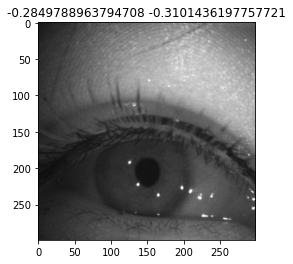

In [ ]:
train_dataset1.show(250)

(X,Y)

In [ ]:
class Inceptionv3_regression(nn.Module):

    def __init__(self, arch,ps=0.5):
        super(Inceptionv3_regression,self).__init__()
        self.encoder = create_body(arch)        #fastai function that creates an encoder given an architecture
        self.fc1 = create_head(1024,1,ps=ps)    #fastai function that creates a head
        self.fc2 = create_head(1024,1,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        label_x = self.fc1(x)
        label_y = self.fc2(x)

        return [label_x, label_y]


In [ ]:
class LossWrapper(nn.Module):
    def __init__(self, task_num):
        super(LossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, label_x, label_y):

        mse = MSELossFlat()

        loss0 = mse(preds[0], label_x)
        loss1 = mse(preds[1], label_y)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        
        return loss0+loss1

In [ ]:
def rmse_x(preds, label_x, label_y): return root_mean_squared_error(preds[0], label_x)
def rmse_y(preds, label_x, label_y): return root_mean_squared_error(preds[0], label_y)
metrics = [rmse_x, rmse_y]

In [ ]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

In [ ]:
def forward_inception_v3(self, x):
    x = self.Conv2d_1a_3x3(x)
    x = self.Conv2d_2a_3x3(x)
    x = self.Conv2d_2b_3x3(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = self.Conv2d_3b_1x1(x)
    x = self.Conv2d_4a_3x3(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2)
    x = self.Mixed_5b(x)
    x = self.Mixed_5c(x)
    x = self.Mixed_5d(x)
    x = self.Mixed_6a(x)
    x = self.Mixed_6b(x)
    x = self.Mixed_6c(x)        
    x = self.Mixed_6d(x)        
    x = self.Mixed_6e(x)        
    if self.training and self.aux_logits:
        aux = self.AuxLogits(x)
    x = self.Mixed_7a(x)        
    x = self.Mixed_7b(x)        
    x = self.Mixed_7c(x)
    return x

In [ ]:
Inception3.forward = forward_inception_v3

In [ ]:
def inception_v3_cut(pretrained=False):    
    model = inception_v3(pretrained)
    return nn.Sequential(model)

In [ ]:
model = Inceptionv3_regression(inception_v3_cut, ps=0.25)
loss_func = LossWrapper(3).to(data1.device) #just making sure the loss is on the gpu

In [ ]:
learn = Learner(data1, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

learn.model = convert_act_cls(learn.model, nn.ReLU, Mish())

#splitting the model so that I can use discriminative learning rates
#learn.split([learn.model.encoder[:6], learn.model.encoder[6:], nn.ModuleList([learn.model.fc1, learn.model.fc2])]);

#first I'll train only the last layer group (the heads)
#learn.freeze()

In [ ]:
torch.cuda.get_device_name()
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [ ]:
print(model)

Inceptionv3_regression(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): Mish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

epoch,train_loss,valid_loss,rmse_x,rmse_y,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 4.79E-05


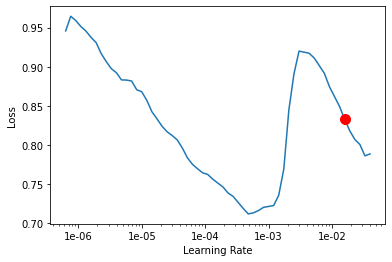

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
#learn = learn.load('stage-1_1')

In [ ]:
#learn.fit_one_cycle()

In [ ]:
learn.fit_one_cycle(3,max_lr=1e-7, callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='stage-1')])

epoch,train_loss,valid_loss,rmse_x,rmse_y,time


In [ ]:
learn.fit_one_cycle(1,max_lr=1e-4, callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='stage-1')])

In [ ]:
learn = learn.load("stage-1_0")

INFERENCES

In [ ]:
#inception xy
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_inceptionv3")


In [ ]:
#inception predictor xy
class EyeGazePredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms(do_flip=False,flip_vert=False,max_zoom=1.05,max_warp=0)[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 227)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        label_x = torch.exp(preds[0]).item()
        label_y = torch.exp(preds[1]).item()
        return label_x, label_y

In [ ]:
idx = 200
data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
seq_id,filename = df1.unique_id.iloc[idx].split('_')
img_path = os.path.join(data_dir+'/'+seq_id,filename)
img = PIL.Image.open(img_path).convert('RGB')
img 

In [ ]:
#inception predictor
eyegaze_predictor = EyeGazePredictor(trained_model)


In [ ]:
print(eyegaze_predictor.predict(img))


In [ ]:
df1.iloc[idx]

accuracy

In [ ]:
GazeX = eyegaze_predictor.predict(img)[0]
GazeY = eyegaze_predictor.predict(img)[1]
Z = eyegaze_predictor2.predict(img)
GT_x = df1.iloc[idx].x
GT_y = df1.iloc[idx].y
xpixels = 0
ypixels = 0
offset = 0
mu = 0.28

In [ ]:
OSD = mu * math.sqrt(pow((GazeX - xpixels/2),2) + pow((ypixels - GazeY + offset),2))
gazeangle = math.atan(OSD/Z)
EGP = math.sqrt(pow(GazeX, 2) + pow(GazeY, 2) + pow(Z, 2))
pix_dist = math.sqrt(pow((GT_x - GazeX), 2) + pow((GT_y - GazeY), 2))
angacc = (mu * pix_dist * (pow(math.cos(gazeangle), 2)))/EGP
print(OSD, EGP)
print(angacc, math.degrees(angacc))

In [ ]:
from tqdm import tqdm

data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
eyegaze_predictor = EyeGazePredictor(trained_model)
avg_angacc = 0
f = open('/content/drive/MyDrive/FYP/Notebooks/xy.txt','a')
for idx in tqdm(range(len(df1))):
  seq_id,filename = df1.unique_id.iloc[idx].split('_')
  img_path = os.path.join(data_dir+'/'+seq_id,filename)
  img = PIL.Image.open(img_path).convert('RGB')
  #print(eyegaze_predictor.predict(img))
  GazeX = eyegaze_predictor.predict(img)[0]
  GazeY = eyegaze_predictor.predict(img)[1]
  f.write(str(GazeX))
  f.write(',')
  f.write(str(GazeY))
  f.write('\n')
  

In [ ]:
print(math.degrees(avg_angacc/len(df1)))